# Q1: Character-Level RNN Language Model

This notebook implements a character-level RNN language model to predict the next character given previous characters.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


## Step 1: Prepare Toy Data


In [ ]:
# Create toy corpus
toy_corpus = """
hello world
hello there
help me
help please
hello everyone
help yourself
hello friend
help needed
"""

print("Toy corpus:")
print(toy_corpus)


Toy corpus:

hello world
hello there
help me
help please
hello everyone
help yourself
hello friend
help needed



## Step 2: Create Character Vocabulary and Dataset


In [ ]:
# Build character vocabulary
chars = sorted(list(set(toy_corpus)))
vocab_size = len(chars)
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {chars}")
print(f"Char to index mapping: {char_to_idx}")


Vocabulary size: 20
Characters: ['\n', ' ', 'a', 'd', 'e', 'f', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
Char to index mapping: {'\n': 0, ' ': 1, 'a': 2, 'd': 3, 'e': 4, 'f': 5, 'h': 6, 'i': 7, 'l': 8, 'm': 9, 'n': 10, 'o': 11, 'p': 12, 'r': 13, 's': 14, 't': 15, 'u': 16, 'v': 17, 'w': 18, 'y': 19}


In [ ]:
# Convert text to indices
def text_to_indices(text):
    return [char_to_idx[ch] for ch in text]

# Create sequences for training
# Use adaptive sequence length based on corpus size
data = text_to_indices(toy_corpus)
sequence_length = min(50, len(data) // 2)  # Use half of data length, max 50
if sequence_length < 5:
    sequence_length = 5  # Minimum sequence length

# Create input-target pairs
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+1:i+seq_len+1])
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

X, y = create_sequences(data, sequence_length)
print(f"Data length: {len(data)} characters")
print(f"Sequence length: {sequence_length}")
print(f"Input shape: {X.shape}, Target shape: {y.shape}")


Data length: 99 characters
Sequence length: 49
Input shape: torch.Size([50, 49]), Target shape: torch.Size([50, 49])


## Step 3: Define RNN Model


In [ ]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # RNN layer (using LSTM)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        rnn_out, hidden = self.rnn(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        output = self.fc(rnn_out)  # (batch_size, seq_len, vocab_size)
        return output, hidden

# Initialize model
model = CharRNN(vocab_size, embed_dim=64, hidden_dim=128, num_layers=1)
print(model)


CharRNN(
  (embedding): Embedding(20, 64)
  (rnn): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=20, bias=True)
)


## Step 4: Training Setup


In [ ]:
# Training parameters
num_epochs = 20
learning_rate = 0.001

# Adaptive batch size based on dataset size
batch_size = min(64, len(X))
if batch_size == 0:
    batch_size = 1

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset size: {len(X)} sequences")
print(f"Batch size: {batch_size}")
print(f"Number of epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")


Dataset size: 50 sequences
Batch size: 50
Number of epochs: 20
Learning rate: 0.001


## Step 5: Training Loop


In [ ]:
# Training loop with teacher forcing
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        
        # Forward pass (teacher forcing: using true previous char as input)
        output, _ = model(batch_X)
        
        # Reshape for loss calculation
        output = output.reshape(-1, vocab_size)
        batch_y = batch_y.reshape(-1)
        
        # Calculate loss
        loss = criterion(output, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training completed!")


Epoch [5/20], Loss: 2.8314
Epoch [10/20], Loss: 2.5912
Epoch [15/20], Loss: 2.2937
Epoch [20/20], Loss: 2.0881
Training completed!


## Step 6: Plot Training Loss Curve


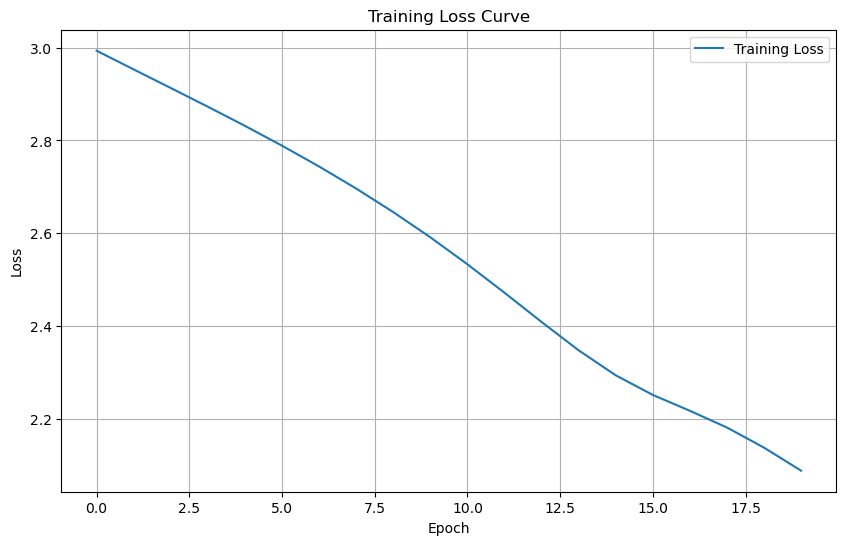

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


## Step 7: Temperature-Controlled Generation


In [ ]:
def generate_text(model, start_text, length=300, temperature=1.0):
    """Generate text using temperature-controlled sampling"""
    model.eval()
    generated = start_text
    hidden = None
    
    # Convert start text to indices
    input_seq = text_to_indices(start_text)
    input_tensor = torch.tensor([input_seq], dtype=torch.long)
    
    with torch.no_grad():
        for _ in range(length):
            # Get prediction
            output, hidden = model(input_tensor, hidden)
            
            # Get last character's logits
            logits = output[0, -1, :] / temperature
            
            # Apply softmax and sample
            probs = torch.softmax(logits, dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            
            # Append to generated text
            generated += idx_to_char[next_char_idx]
            
            # Update input for next iteration
            input_tensor = torch.tensor([[next_char_idx]], dtype=torch.long)
    
    return generated

# Generate samples with different temperatures
print("=" * 60)
print("Temperature = 0.7 (More conservative):")
print("=" * 60)
print(generate_text(model, "hello", length=200, temperature=0.7))

print("\n" + "=" * 60)
print("Temperature = 1.0 (Balanced):")
print("=" * 60)
print(generate_text(model, "hello", length=200, temperature=1.0))

print("\n" + "=" * 60)
print("Temperature = 1.2 (More creative):")
print("=" * 60)
print(generate_text(model, "hello", length=200, temperature=1.2))


Temperature = 0.7 (More conservative):
hellono heeellpee
oelloello enle
e
lyooon eelhele
 
lelelplvelrepell orepel oureleeelrlie
lee pell heelallllel
hllp oewew

eeleellelo el
 hopeelle
ohee
lp vweoelehelelnloonel ptefellp 
hoe
eeel ovll lpee
e

Temperature = 1.0 (Balanced):
hellooeem
efuevwil m
y
 prsul ehellemselopprdweeef epl leermre
rp  erllol  e
hoheoponee
eepleonoemleh
ehe
eellliye
l laeeelve
elo
ellvfhoneo
welle
syyhe
erehevthloe
eellloheeyele
 ileeeullp ieple ee
pltlel

Temperature = 1.2 (More creative):
helloovp
onwnroeehseimhevelromom o
eh
e
ryyl arl s
lue uoe

lelloeell mrenealstellnmesewlpoemlaile
o
pelmllrflo fp r
delpt
pylv
omseolt
ph ntpee
lppl
d

ve

hlserlene
fhpaellelrpelp lhlr us  eheheehehloooe


## Step 8: Reflection

**What changes when you vary sequence length, hidden size, and temperature?**

1. **Sequence Length**: Longer sequences allow the model to capture more context and dependencies, but require more memory and computation. Shorter sequences are faster but may miss long-range patterns.

2. **Hidden Size**: Larger hidden dimensions give the model more capacity to learn complex patterns, but increase the risk of overfitting and require more training time. Smaller hidden sizes are more efficient but may limit model expressiveness.

3. **Temperature**: Lower temperatures (0.7) make the model more conservative and predictable, choosing more likely characters. Higher temperatures (1.2) increase creativity and diversity but may produce less coherent text. Temperature 1.0 provides a balanced sampling from the learned distribution.
